
---
title: "Generating a predictive distribution for the number of people attending your party"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

A few years back when I started writing on this blog, I wrote a piece called [The probability of making your Friday night party](https://benslack19.github.io/data%20science/statistics/social_schedule/). Well the opportunity has now presented itself for predicting the number of people attending *our* party. This question came up between my wife and I since we're trying to plan party logistics.

You might be asking yourself, "Ben, why don't you just request RSVPs and get a more definitive number?" There are several reasons for this:
1. The number of people in attendance is not only a key factor in party planning, but a factor that both affects and is *affected by* logistics. If you build the party, they will come. Therefore, it would be helpful to get a probability distribution for the number of attendees even before sending an Evite or request RSVPs.
1. Friends and family have increasingly busy schedules and sometimes RSVPs aren't reliable. We know they'd love to attend but have other barriers with complicated dependencies. Think caregiving for older parents, kids, or pets; travel preferences; already reserved tickets to sporting events; hair salon appointments (hey sometimes they're hard to get).
1. In a post-pandemic world, it's more acceptable to be a no-show if you're experiencing any health symptoms.
1. I'm a geek and thought of the fun way this can be answered with probability and statistics!

Here are the fun, geeky aspects of the problem.
- Estimating the total number of people might come means considering that the probabilities of coming vary across individuals. You can imagine that a grandmother will very likely come (probability of 0.9) while a co-worker with young kids is more of a toss-up (probability of 0.5). That's why an initial, naive approach for using the binomial distribution for the entire guest list would not be optimal; the binomial distribution would assumes constant probability across the individuals. However, one can apply binomial distribution to a group of friends or a family unit. Maybe one parent goes, and that parent can take 1 or 2 kids.
- Determining the expected value is relatively easy. Understanding the uncertainty is harder.

The core analytical aspect of this problem was addressed by a [1993](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWQ1eDd1dnI4YnBieHRoZTdoNzJycXNhYTFmeXl3dWE4YWlpZTA5NCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/6DTyIDQ1VfQnC/giphy.gif) paper by Ken Butler and Michael Stephens called [The Distribution of a Sum of Binomial Random Variables ](https://www.semanticscholar.org/paper/The-Distribution-of-a-Sum-of-Binomial-Random-Butler-Stephens/a85017f8ef59cefc315aec62c06fb8bb645b720d). However, we can re-derive some of the work through reasoning through just a few fundamental probability rules such as:
- Identifying the probabilities of jointly events which are otherwise independent means multiplying the probabilities of the individual events ("and" statements)
- Identifying the total probability of several events occurring means adding the probabilities of the individual events ("or" statements)
- The sum of the probabilities of all possible events must add to 1.

Let's get started!

In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binom
from scipy.stats._distn_infrastructure import rv_discrete_frozen

# Probability distributions for each group
Here is a visualization of the problem. We can have probability distributions for different groups on an invite list. For explanation purposes,  let's imagine that we're considering inviting three groups: a set of grandparents, neighbors, and a busy co-worker with their family with probability of attending as 90%, 75% for neighbors, and 50%, respectively. These groups would have binomial distributions that look like this.

In [21]:
# create a dataframe that holds the number and probability for each group
df_data = pd.DataFrame(
    {
        "group": ["Grandparents", "Neighbors", "Co-worker's family"],
        "n": [2, 4, 5],
        "p": [0.9, 0.5, 0.2]
    }
)
df_data

,group,n,p
0,Grandparents,2,0.9
1,Neighbors,4,0.5
2,Co-worker's family,5,0.2


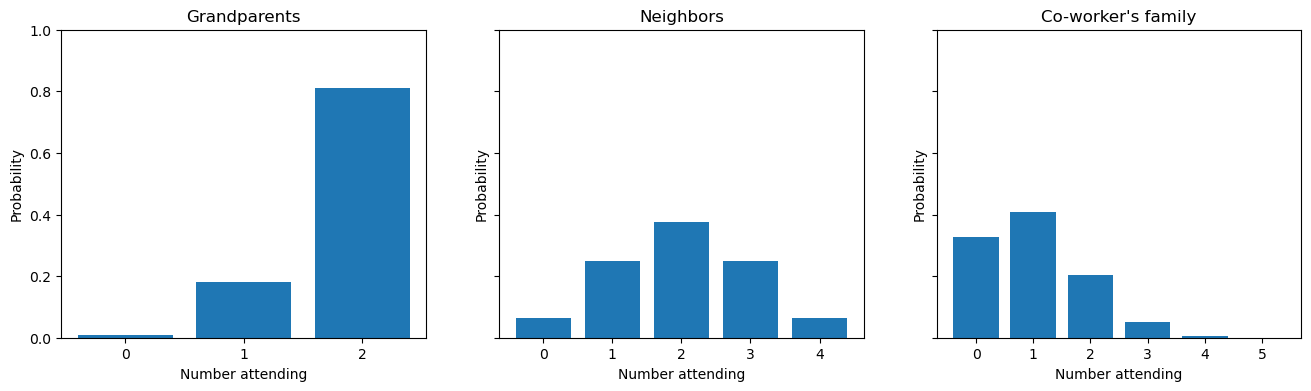

In [22]:
# Visualize the probability distribution for each grouop
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for (i, row), ax  in zip(df_data.iterrows(), axes.flat):
    rv = binom(row['n'], row['p'])
    x = np.arange(row['n']+1)
    ax.bar(x, rv.pmf(x))
    ax.set(
        title = row['group'],
        ylim = (0, 1),
        xticks = x,
        xlabel = "Number attending",
        ylabel = "Probability"
        )


# Deriving the algorithm for the distribution of summed discrete random variables
As you can see, it's fairly straighforward to get a distribution for the individual groups for attendance. But how do we get a distribution for the *total* number of people attending?

We can look at the Butler and Stephens paper and see that they approached this with an algorithm for the exact distribution while also examining approximations. For our purposes, we'll focus on the exact distribution, especially since there was this line from their paper "With modern computing facilities, it is possible to calculate the exact distribution of S." Remember this was written in 1993 when computers looked like [this](https://giphy.com/gifs/90s-computer-dV3GXudtLAbTi). Nevertheless, when you see the calculations carried out, you can appreciate why a statement was warranted and why they explored approximations, especially as the number of samples (possible attendees in this case) scales.

The heart of the algorithm is the following equation.

$$ P(Y + Z=j) = \sum_{i=0}^{j} P(Y=i) P(Z = j-i) $$

$Y$ and $Z$ are two discrete random variables (e.g. integers) which makes sense since we don't want a fraction of a person attending (maybe if it was Halloween?). (While they described $Y$ and $Z$ as variables with a binomial distribution, we can see later why this isn't strictly necessary.) They talk about focusing on only two groups at a time, then once that has been calculated, adding in an additional group recursively until all have been accounted for. 

We can reason through the above formula with our putative invites. We'll go back to the dataframe that produced the above figure where each row contains a group, the number of people (n), and the probability of attendance (p) but limit it to the first two rows where the `Grandparents` group is the $Y$ variable and the `Neighbors` group is the $Z$ variable.

In [23]:
df_data.head(2)

,group,n,p
0,Grandparents,2,0.9
1,Neighbors,4,0.5


And let's look at each group's probability distribution in table form.

In [24]:
# grandparents
i_vals_gp = range(df_data.loc[0, "n"] + 1)
Y = binom(df_data.loc[0, "n"], df_data.loc[0, "p"])
df_Y = pd.DataFrame({'x':i_vals_gp, 'probability':Y.pmf(i_vals_gp)})
df_Y

,x,probability
0,0,0.01
1,1,0.18
2,2,0.81


In [25]:
# neighbors
i_vals_nb = range(df_data.loc[1, "n"] + 1)
Z = binom(df_data.loc[1, "n"], df_data.loc[1, "p"])
df_Z = pd.DataFrame({'x':i_vals_nb, 'probability':Z.pmf(i_vals_nb)})
df_Z

,x,probability
0,0,0.0625
1,1,0.2500
2,2,0.3750
3,3,0.2500
4,4,0.0625


We can then think now about the probabilities for each possibility of total attendance which we'll designate with the variable $j$. That means, $j$ is bounded by 0 (no one comes, wah wah) to 6 (everyone shows up). Let's reason this out. I'm italicizing some keywords below since we can link *and* statements to multiplying probabilities and *or* statements to adding probabilities.

- 0 total attendees ($j=0$): That means 0 grandparents show up *and* 0 neighbors show up. The probability of both happening means multiplying the probabilities ($0.01 \times 0.003906$).
- 1 total attendee ($j=1$): That means *either* 1 grandparent shows up *and* 0 neighbors show up ($0.18 \times 0.003906$) *or* 0 grandparents show up *and* 1 neighbor shows up ($0.01 \times 0.046875$). This means adding the two possibilities ($0.18 \times 0.003906 + 0.01 \times 0.046875$)
- 2 total attendees ($j=2$): Here's where it starts get more complicated. That means *either* 2 grandparents show up *and* 0 neighbors show up ($0.81 \times 0.003906$) *or* 1 grandparent shows up *and* 1 neighbor shows up ($0.18 \times 0.046875$) *or* 0 grandparents show up *and* 2 neighbors show up ($0.01 \times 0.210938$). This means adding these three possibilities ($0.81 \times 0.003906 + 0.18 \times 0.046875 + 0.01 \times 0.210938$).

Hopefully you start to see the pattern and can figure out the logic for the remaining values of $j$ and now see how this leads to the above equation. Let's flesh this out with code.

In [26]:
def convert_binom_pmf(rv: rv_discrete_frozen) -> dict:
    """Convert a random variable's binomial distribution PMF to a dictionary.

    Parameters
    ----------
    rv
        Random variable Y representing discrete values
        
    Returns
    -------
    :
        Dictionary of probabilities for each j
    
    """
    j = rv.support()[1]
    return {x:rv.pmf(x) for x in range(j+1)}


def probability_for_j_total_people(
    j: int, rv_Y_prob: dict, rv_Z_prob: dict
) -> float:
    """Determine the probability of j people attending, given two random variables.

    Parameters
    ----------
    j
        The number of total attendees.
    rv_Y_prob
        Probability distribution of random variable Y as a dictionary
    rv_Z_prob
        Probability distribution of random variable Y as a dictionary
        
    Returns
    -------
    :
        Total probability of j
    """
    combinations = itertools.product(range(j + 1), repeat=2)
    total_j_combinations = [(y, z) for y, z in combinations if y + z == j]  # gives all y+z combinations that add up to j
    prob = 0
    x = range(j + 1)
    for combo in total_j_combinations:
        if (combo[0] in rv_Y_prob) and (combo[1] in rv_Z_prob):
            prob_combo = rv_Y_prob[combo[0]] * rv_Z_prob[combo[1]]
            prob += prob_combo
    return prob

In [27]:
total_prob = 0   # sanity check that the total probability adds up to 1
j_prob = dict()  # cache the probabilities in a dictionary
max_attendees = df_data.head(2)['n'].sum()
for j in range(max_attendees + 1):
    rv_Y_prob = convert_binom_pmf(Y)
    rv_Z_prob = convert_binom_pmf(Z)
    prob = probability_for_j_total_people(j, rv_Y_prob, rv_Z_prob)
    print(f"Probability for {j} total people: {prob:0.5f}")
    j_prob[j] = prob
    total_prob += prob
    
print(f"\nTotal probability after accounting for all cases: {total_prob:0.4f}")

Probability for 0 total people: 0.00062
Probability for 1 total people: 0.01375
Probability for 2 total people: 0.09938
Probability for 3 total people: 0.27250
Probability for 4 total people: 0.34937
Probability for 5 total people: 0.21375
Probability for 6 total people: 0.05063

Total probability after accounting for all cases: 1.0000


Awesome! It looks like we've successfully carried out the equation. But remember we've only done the first two groups. The next step is to add in the remaining group (co-worker's family) using the same process. But the probability distribution of our new $Y$ variable is what we just calculated, which is now stored in  a dictionary `j_prob`. As I indicated above, there's really no requirement that the distribution be binomial, it just has to be discrete.

In [28]:
# Let's recall the n and p of the remaining group
df_data.tail(1)

,group,n,p
2,Co-worker's family,5,0.2


We can carry out the same steps.

In [29]:
# coworkers
i_vals_cw = range(df_data.loc[2, "n"] + 1)
new_Z = binom(df_data.loc[2, "n"], df_data.loc[2, "p"])
rv_new_Z_prob = convert_binom_pmf(new_Z)  # put in dictionary form for our function
rv_new_Z_prob

{0: 0.3276799999999998,
 1: 0.4095999999999999,
 2: 0.20479999999999987,
 3: 0.051200000000000016,
 4: 0.0064,
 5: 0.0003200000000000001}

In [30]:
df_data

,group,n,p
0,Grandparents,2,0.9
1,Neighbors,4,0.5
2,Co-worker's family,5,0.2


Recall that the putative total invite list was 11 people. Therefore, our probability distribution should give probabilities between 0 and 11.

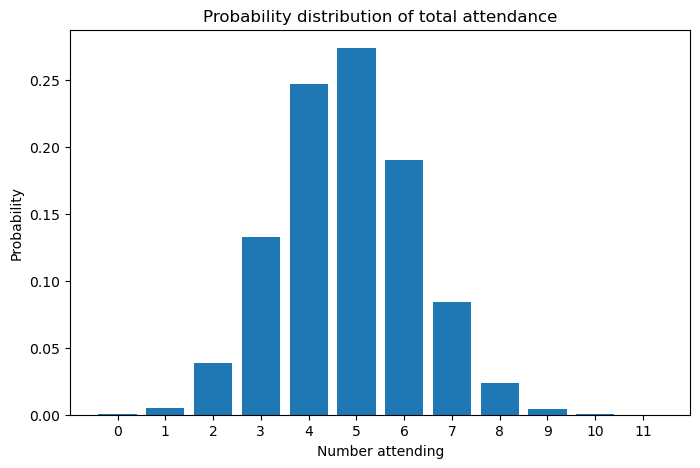

In [31]:
j_prob_new = dict()  # cache the probabilities in a dictionary
for j in range(df_data["n"].sum() + 1):
    prob = probability_for_j_total_people(
        j, j_prob, rv_new_Z_prob
    )  # j_prob is what we calculated for the first two groups
    j_prob_new[j] = prob

f, ax = plt.subplots(figsize=(8, 5))

ax.bar(j_prob_new.keys(), j_prob_new.values())
ax.set(
    title="Probability distribution of total attendance",
    xticks=list(j_prob_new.keys()),
    xlabel="Number attending",
    ylabel="Probability",
);

# A user-friendly function
OK! So it now looks like we have our final, exact distribution for the sum of all variables, what Butler and Stephens called $S$. We can make the production of this distribution much more user friendly with another couple of functions. Let's produce this by passing in our dataframe.

In [32]:
df_data

,group,n,p
0,Grandparents,2,0.9
1,Neighbors,4,0.5
2,Co-worker's family,5,0.2


In [33]:
def sum_of_discrete_rvs_exact_calculation(pmf_list: list) -> pd.Series:
    """Determine the probability distribution using recursion.

    Perform the exact calculation on the first two rows (e.g. random variables). 
    If more than two rows exist, treat the resulting probability distribution as 
    a random variable and add the third row. Repeat until all rows have been
    accounted for.

    Parameters
    ----------
    pmf_list
        A list of dictionaries containing the probability mass functions of
        different groups attending.
    
    Returns
    -------
    :
        Final probability distribution as a pandas Series
    """
    pmf_list = pmf_list.copy() # prevent the original list from being altered
    
    s_prob = dict()
    max_attendees = max(list(pmf_list[0].keys())) + max(list(pmf_list[1].keys()))
    for j in range(max_attendees + 1):
        prob = probability_for_j_total_people(
                j, pmf_list[0], pmf_list[1]
        )
        s_prob[j] = prob
    
    # base case
    if len(pmf_list) == 2:
        return s_prob
    
    # apply recursion
    else:
        # remove the first element and then replace the remaining first element with the new dictionary
        pmf_list.pop(0)
        pmf_list[0] = s_prob
        return sum_of_discrete_rvs_exact_calculation(pmf_list)



In [34]:
# put each group in a probability distribution
pmf_list_party = [convert_binom_pmf(binom(df_data.loc[i, "n"], df_data.loc[i, "p"])) for i in df_data.index]
assert j_prob_new == sum_of_discrete_rvs_exact_calculation(pmf_list_party)

In [35]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Apr 12 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

numpy     : 1.25.2
seaborn   : 0.13.2
matplotlib: 3.8.2
pandas    : 2.2.0

Watermark: 2.4.3

